# Recurrent learning

In this file the network is working with a feedback, online learning is used to make a correction when it might exagerates. 

In [1]:
import csv 
import os 
import math 
import numpy as np
from datetime import datetime
dpath = '../dataset/preprocessed/'
file_name = 'A146020302.csv'

#Makes the time a continuous value to work with ESN.
def time_linearisation(date): 
    format_code = "%Y%m%d"
    dt = datetime.strptime(date, format_code)

    # Week day
    dow = dt.weekday()
    dow_sin = math.sin(2 * math.pi * dow / 7)
    dow_cos = math.cos(2 * math.pi * dow / 7)

    # Month day
    dom = dt.day - 1
    days_in_month = 31  # number of days in a month approximation
    dom_sin = math.sin(2 * math.pi * dom / days_in_month)
    dom_cos = math.cos(2 * math.pi * dom / days_in_month)

    # Day of Year
    doy = dt.timetuple().tm_yday - 1
    days_in_year = 365.25  # number of days in a year approximation
    doy_sin = math.sin(2 * math.pi * doy / days_in_year)
    doy_cos = math.cos(2 * math.pi * doy / days_in_year)

    # Months
    month = dt.month - 1
    month_sin = math.sin(2 * math.pi * month / 12)
    month_cos = math.cos(2 * math.pi * month / 12)

    return np.array([
        doy_sin, doy_cos,
    ])

print(time_linearisation("20230630"))  # Example usage


[ 0.04514102 -0.99898062]


Same as in the previous file, gathering data. 

In [2]:
# Load preprocessed data

# inputs : Qls (1), Qmmj (2), Ptot (9), Fsol(10), Temp (11), E_ou (12), E_PE (13), E_PM (14), Vent (15), Humi (16), Dli (17), SSI (18), IHGR (19), TN (22), TX (23), niveau_deau (24)

def load_X_Y(filepath):
    X = []
    inputs_columns = [ 1, 9, 11, 24 ]
    with open(filepath, mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if not row or row[0].startswith("D"):
                continue
            time_features = time_linearisation(row[0])
            X.append(np.concatenate([time_features] + [[float(row[i])] for i in inputs_columns]))
        return np.array(X)


In [3]:
import matplotlib.pyplot as plt 
def plot_results(y_pred, y_test, sample=800):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
   # plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

Building the network, yet as we saw in the previous file, an ESN with a ridge can not forecast subtilities of the data. This time, an RLS will be used. This time, the forecast will be 48 corresponding to 24h according to the dataset. It should be a good approximation for an electricty producer. 

In [4]:
from reservoirpy.datasets import to_forecasting
def normalize_data(data):
    # Normalizing data between 0 and 1 column by column
    min_vals = data.min(axis=0)
    max_vals = data.max(axis=0)
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data, min_vals, max_vals

data = load_X_Y(dpath + file_name)
data, min_vals, max_vals = normalize_data(data)
x,y= to_forecasting(data[3156:], forecast=7)
print(x.shape, y.shape)
print(y)
y = y[:, -1].reshape(-1, 1) # chosing the data that will be used (electricity consuption)
units = 200 
alpha = 0.009838765758022786
leak_rate = 0.6079924819654108
spectral_radius = 0.8838547867045398
input_scaling = 1.0
connectivity = 0.001983076302206145
input_connectivity = 0.061394244538574685
regularization = 1e-1
seed = 42
X_train1, y_train1 = x[:1500], y[:1500]
X_test1, y_test1 = x[1500:], y[1500:]
X_test1 = np.asarray(X_test1) # chosing the data that will be used (electricity consuption)
X_test1 = X_test1.reshape(X_test1.shape[0], -1) # reshaping data that they could be used by reservoir py
# plot_train_test(X_train1, y_train1, X_test1, y_test1)


(7494, 6) (7494, 6)
[[0.00189458 0.54348387 0.05735962 0.02597403 0.65771812 0.36541353]
 [0.00271635 0.55204571 0.05152375 0.06168831 0.59060403 0.36691729]
 [0.00368529 0.56059216 0.04598463 0.0021645  0.5950783  0.36541353]
 ...
 [0.28084846 0.05057739 0.00350152 0.         0.79194631 0.21804511]
 [0.27315022 0.05441371 0.00357076 0.         0.80313199 0.21503759]
 [0.26551911 0.05838188 0.00370924 0.         0.84787472 0.21203008]]


In [5]:
from reservoirpy.nodes import RLS
from reservoirpy.nodes import Reservoir 
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = RLS(alpha=alpha)


esn_online = reservoir >> readout

In [6]:
readout = RLS(alpha=alpha)
outputs_pre = np.zeros((len(X_train1), 1))

for t, (x_t, y_t) in enumerate(zip(X_train1, y_train1)):
    outputs_pre[t] = esn_online.partial_fit(
        x_t.reshape(1, -1),
        y_t.reshape(1, -1)
    )

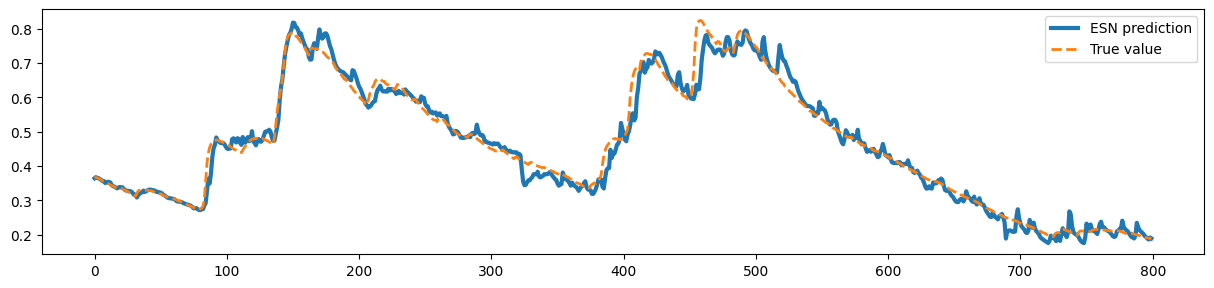

In [7]:
plot_results(outputs_pre, y_train1,800)

In [8]:

esn_online = reservoir >> readout
esn_online.partial_fit(X_train1, y_train1)
pred_online = esn_online.run(X_test1)

292.85 299.5
-0.02280321910858543
1.5335501925786161
(5994, 1) (5994, 1)


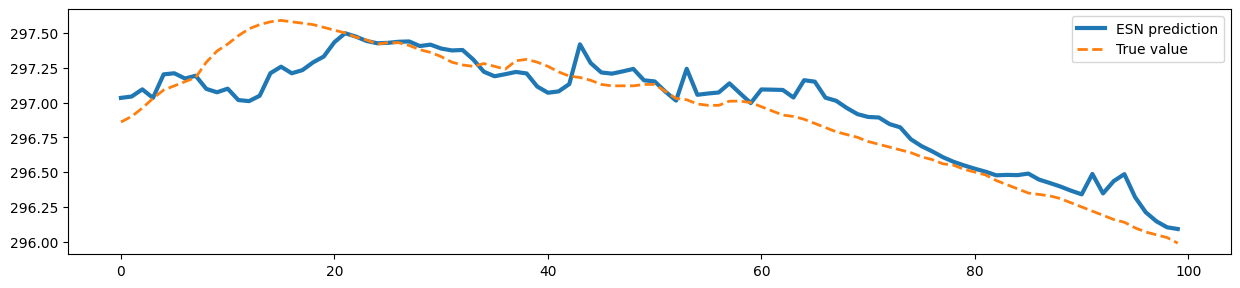

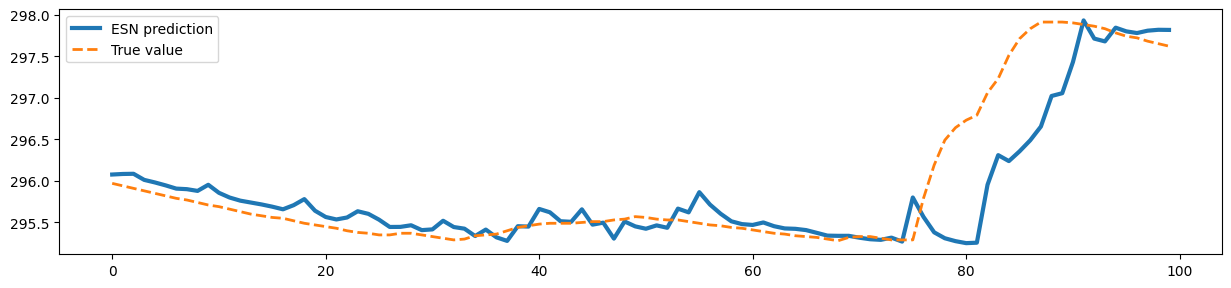

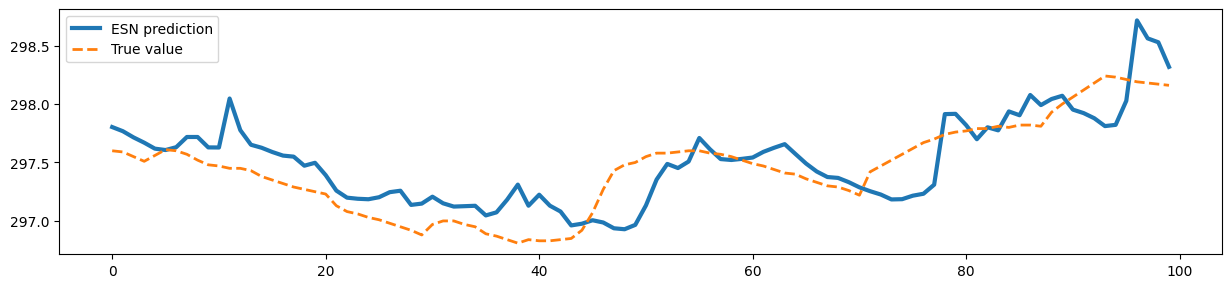

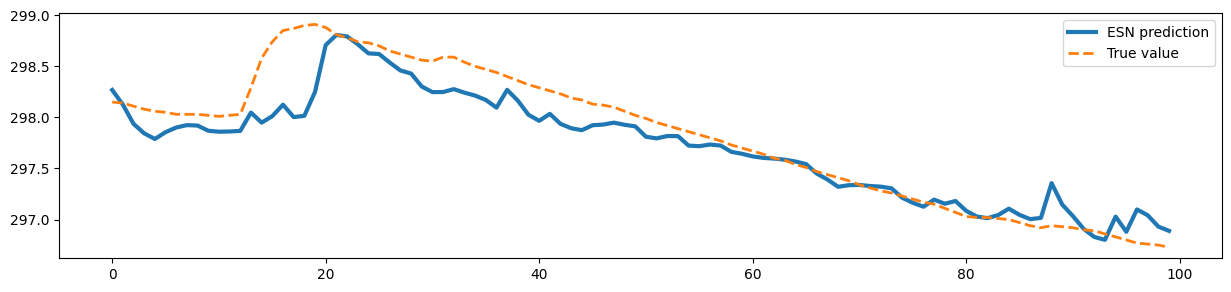

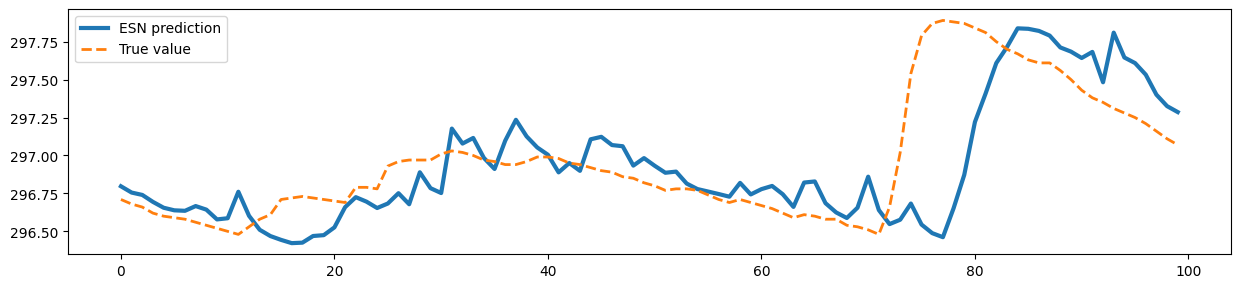

In [9]:
def unnormalize_data(normalized_data, min_vals, max_vals):
    return normalized_data * (max_vals - min_vals) + min_vals


print( min_vals[-1], max_vals[-1])
pred_data = unnormalize_data(pred_online, min_vals[-1], max_vals[-1])
y_test_data = unnormalize_data(y_test1, min_vals[-1], max_vals[-1])
print(np.mean(y_test_data - pred_data))
print(np.max(y_test_data - pred_data))

_from = 100
_to = 200
step = _to - _from

print(pred_data.shape, y_test_data.shape)

# plot_results(pred_online[_from:],y_test1[_from:], sample=_to - _from)
for i in range(5):
    plot_results(pred_data[_from+i*step :],y_test_data[_from+i*step:], sample=step) 

With this approach, the systems is better to forecast values thanks to the feedback that allows the continue learning.  

In the group we are amazed and questionning because the reserver is able to forecast even though data is not normalized. We are wondering if this is not thanks of the readout which is marking this approaximations.  

We tried to use normalized data, but this resulted to a not working behavior then bad forecastings. We are willing to work on this for the next days to find why this was not woeking as expected.  

In [10]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result of the loss function.
# You can add any additional metrics or information with other keys in the dict. See hyperopt documentation for more informations.
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.nodes import Ridge

In [11]:
train_len = 1000
forecast = 7

X_train = x[:train_len]
Y_train = x[forecast : train_len + forecast]

X_test = x[train_len : -forecast]
Y_test = x[train_len + forecast:]

dataset = (X_train, X_test, Y_train, Y_test)

In [23]:
import json
hyperopt_directory = "hyperopt/"
exp_directory = "exps/"
exp_config_directory = "configs/"

exp_name = "hyperopt-input-scaling-multi"
exp_version = 4 # calculate the version number based on existing files in the directory 


hyperopt_config = {
    "exp": exp_name + "-" + str(exp_version),    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 150],             # the number of neurons is fixed to 500
        "sr": ["choice", 0.8838547867045398],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["choice", 0.4981590552238297],    # idem with the leaking rate, from 1e-3 to 1
        # "input_scaling": ["loguniform", [5e-1, 5e-1, 5e-1],[ 1,1,1]], # the input scaling is fixed
        "alpha": ["choice", 0.009838765758022786],        # and so is the regularization parameter.
        "input_connectivity": ["choice", 0.061394244538574685], # exploring input connectivity
        # "connectivity": ["loguniform", 1e-3, 1], # exploring reservoir connectivity
        "seed": ["choice", 1234],          # an other random seed for the ESN initialization
        "input_scaling_1":  ["loguniform", 1e-5, 1e0], 
        "input_scaling_2":  ["loguniform", 1e-5, 1e0], 
        "input_scaling_3":  ["loguniform", 1e-5, 1e0], 
        "input_scaling_4":  ["loguniform", 1e-5, 1e0], 
        "input_scaling_5":  ["loguniform", 1e-5, 1e0],
        "input_scaling_24":  ["choice", 0.7904117777131483],
    }
}

config_file_name = f"{hyperopt_directory}{exp_config_directory}{hyperopt_config['exp']}.config.json"
results_directory = hyperopt_directory + exp_directory + hyperopt_config['exp']

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(config_file_name, "w+") as f:
    json.dump(hyperopt_config, f)

# mkdir results_diretory 
os.makedirs(results_directory, exist_ok=True)

In [24]:
from reservoirpy.mat_gen import bernoulli

def objective(dataset, config, *, N, sr, lr, alpha, input_connectivity, seed, input_scaling_1, input_scaling_2, input_scaling_3, input_scaling_4, input_scaling_5, input_scaling_24):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset
    
    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]
    

    Win_default = bernoulli(N, x_train.shape[1], connectivity=input_connectivity )
    Input_Scaling = [input_scaling_1, input_scaling_2, input_scaling_3, input_scaling_4, input_scaling_5, input_scaling_24]

    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            seed=variable_seed,
            input_connectivity=input_connectivity,
            rc_connectivity=connectivity,
            Win=Win_default * Input_Scaling
        )

        readout = RLS(alpha=alpha)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [25]:
from reservoirpy.hyper import parallel_research
best = parallel_research(objective, dataset, config_file_name, results_directory)

100%|██████████| 200/200 [01:11<00:00,  2.78trial/s, best loss=0.0565]


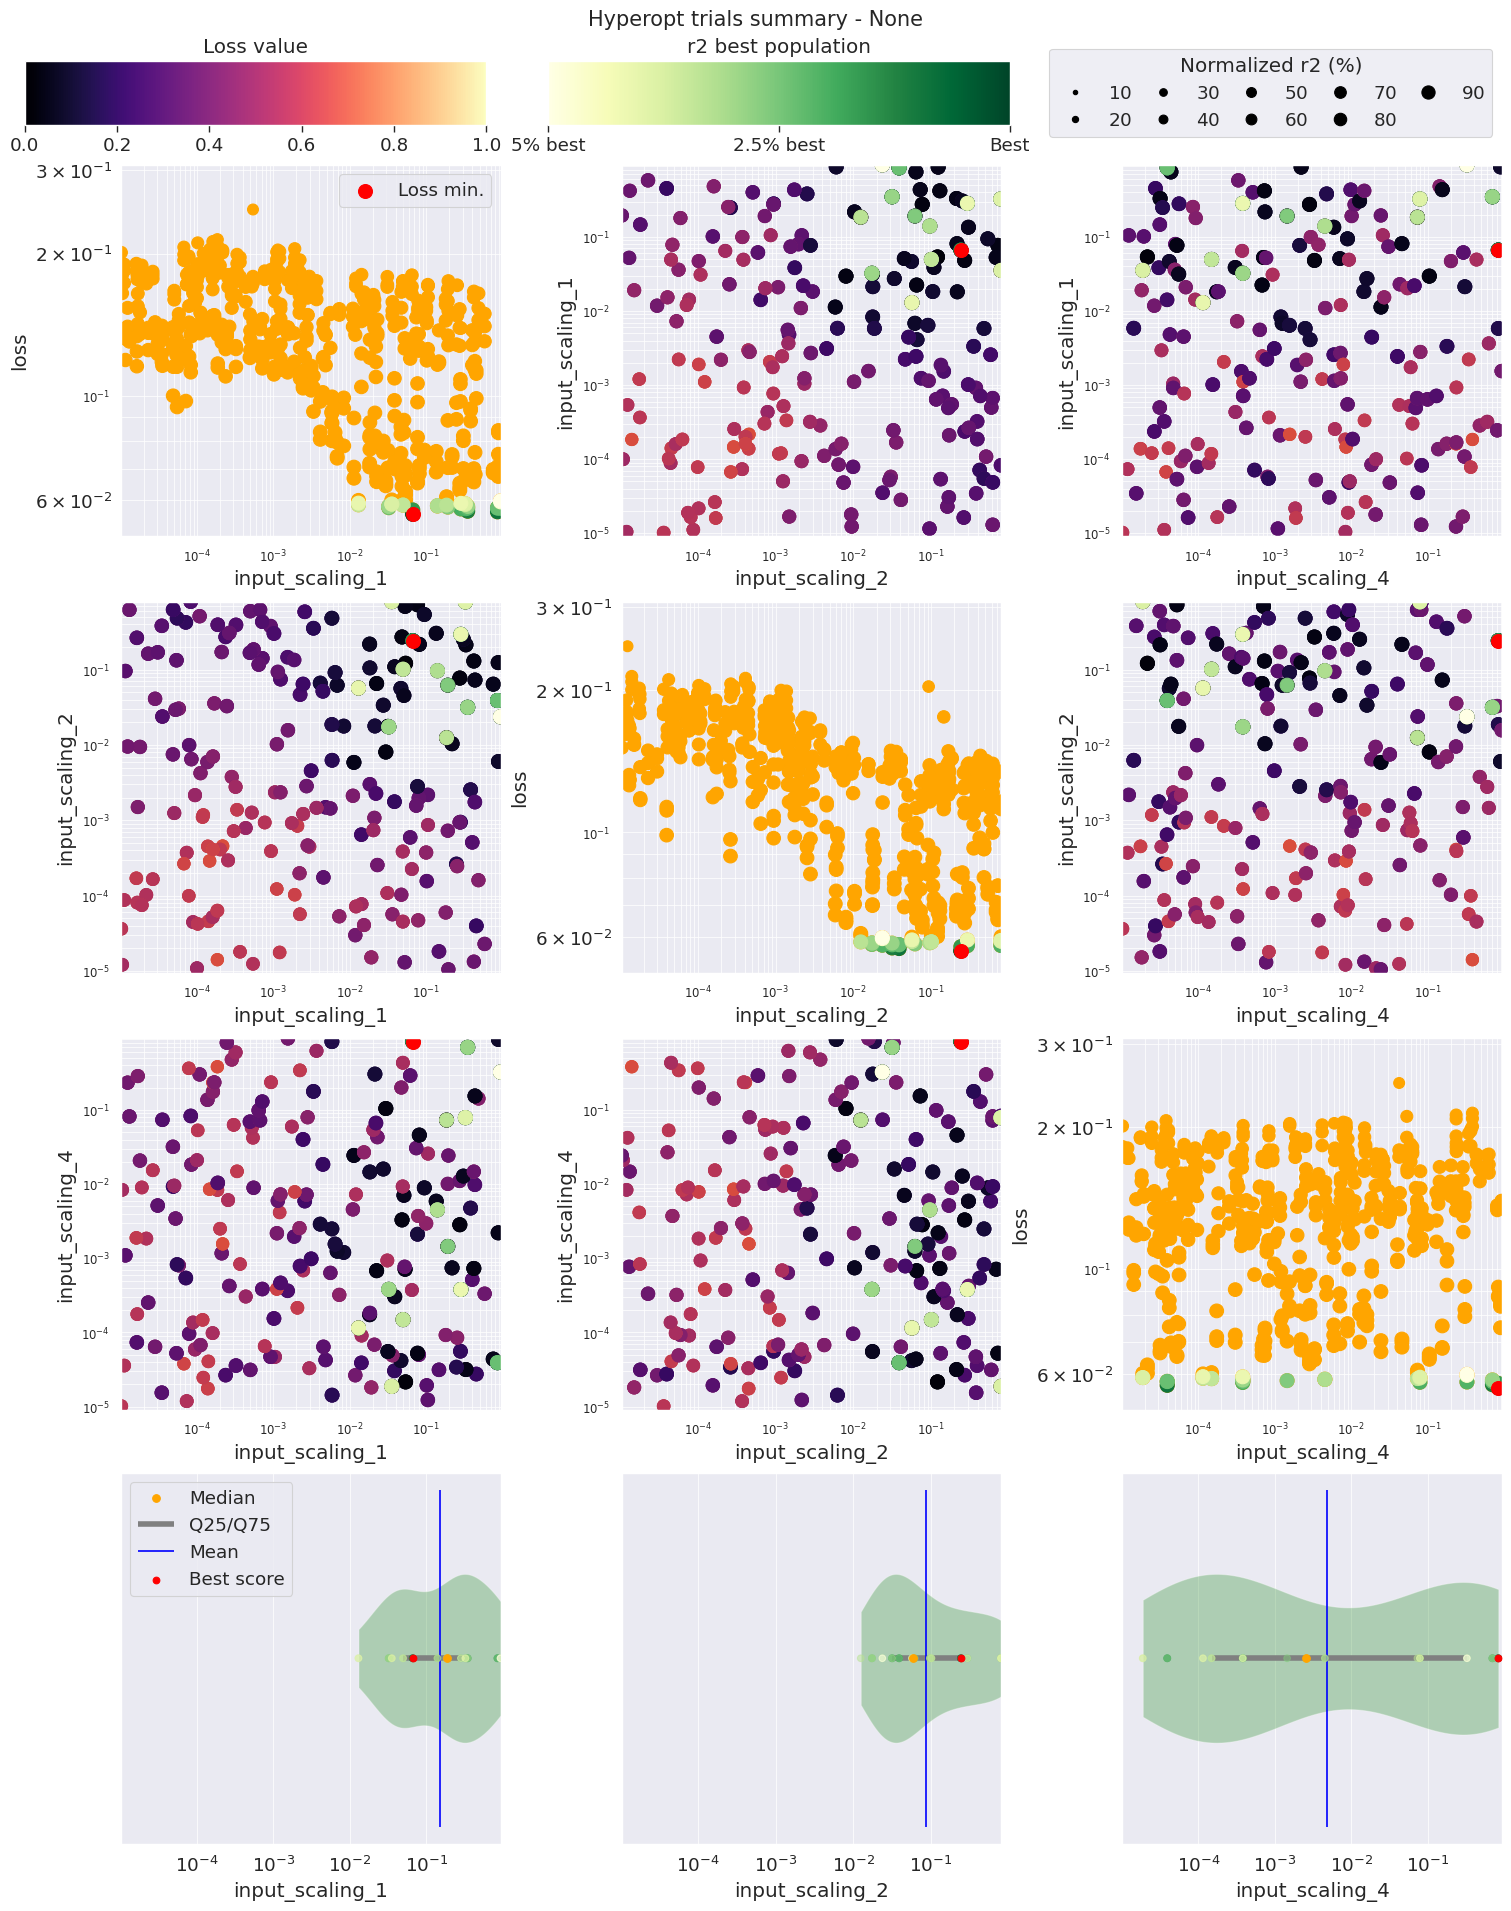

In [26]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(results_directory, ("input_scaling_1", "input_scaling_2", "input_scaling_4"), metric="r2")